Leonard Vorbeck

No Group

Student Number : 2709813

In [1602]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import choice as random_select
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.dpi"] = 93
plt.rcParams["figure.figsize"] = (5,5)

## 1.) Monte Carlo Tree Search

I encapsulated all of the computational logic within the `Node` class. First, it builds a tree recursively from an initial root node. Then, the MCTS Iterations using UCB are defined as methods on the nodes themselves. I apologize for this highly abstract representation, but I will provide a quick demo below to demonstrate how a single node can expand itself to a tree and solve itself.

In [3264]:
class Node:
    terminals = []
    @classmethod
    def get_terminals(cls):
        dist = Node.terminals
        Node.terminals = []
        return dist
    def stats(self): return self.__dict__
    def __init__(self,c, parent=None, is_terminal=False):
        self.value = None if not is_terminal else np.random.uniform(0,100)
        self.is_terminal = is_terminal
        Node.terminals += [self.value] if is_terminal else []
        self.n = 0
        self.c = c
        self.total = 0
        self.right = None
        self.left = None
        self.parent = parent
        self.visited = False
    def UCB(self):
        if self.n == 0:
            return np.inf
        else:
            return self.mean() + self.c*np.sqrt((np.log(self.parent.n)/self.n))
    def mean(self):
        return self.total/self.n

    def insert(self, is_terminal=False):
        if self.right == None:
            self.right = Node(self.c, self, is_terminal)
        else:
            self.right.insert(is_terminal)
        if self.left == None:
            self.left = Node(self.c, self, is_terminal)
        else:
            self.left.insert(is_terminal)
        
    def construct(self, depth):
        for _ in range(depth):
            if _ != depth-1:
                self.insert(is_terminal=False)
            else:
                self.insert(is_terminal=True)
                
    def rollout(self, X=None, verbose=True):
        if X == None:
            X = self.random_walk()
            self.visited = True
        self.n +=1
        self.total += X
        if self.parent != None:
            self.parent.rollout(X=X)
            
    def random_walk(self):
        if self.is_terminal:
            return self.value
        else:
            if np.random.binomial(1, 0.5) == 1:
                return self.right.random_walk()
            else:
                return self.left.random_walk()
            
    def choice(self):
        r_ucb = self.right.UCB()
        l_ucb = self.left.UCB()
        if r_ucb == l_ucb:
            return np.random.choice([self.left, self.right])
        elif r_ucb > l_ucb:
            return self.right
        else:
            return self.left

            
    def display(self,ucb=False):
        lines, _, _, _ = self._display_aux(ucb)
        for line in lines:
            print(line)
            
    def __iter__(self, visualize=False):
        if self.is_terminal:
            return self.rollout()
        elif self.right.is_terminal:
            return self.rollout()
        else:
            chosen = self.choice()
            if not chosen.visited:
                chosen.rollout()
                if visualize:
                    tree.display(ucb=True)
            else:
                chosen.__iter__(visualize)
            
    def solve(self, budget, out=False):
        for _iter in range(budget):
            self.__iter__()
        if self.right.is_terminal:
            if self.right.value > self.left.value:
                return self.right.value
            else:
                return self.left.value
        else:
            if self.right.mean() > self.left.mean():
                print("right") if out else None
                return self.right.solve(budget, out)
            else:
                print("left") if out else None
                return self.left.solve(budget, out)
            
    def _display_aux(self, ucb):
        if self.right is None and self.left is None:
            line = "■" if type(self.value) != int else str(self.value)
            width = len(line)
            height = 1
            middle = width // 2
            return [line], width, height, middle
        left, n, p, x = self.left._display_aux(ucb)
        right, m, q, y = self.right._display_aux(ucb)
        if ucb:
            if self.parent is None:
                ucb_val = "O"
            else:
                ucb_val = str(int(self.UCB())) if self.UCB() < 999999 else "∞"
        s = 'o' if not ucb else ucb_val
        u = len(s)
        first_line = (x + 1) * ' ' + (n - x - 1) * '_' + s + y * '_' + (m - y) * ' '
        second_line = x * ' ' + '/' + (n - x - 1 + u + y) * ' ' + '\\' + (m - y - 1) * ' '
        if p < q:
            left += [n * ' '] * (q - p)
        elif q < p:
            right += [m * ' '] * (p - q)    
        zipped_lines = zip(left, right)
        lines = [first_line, second_line] + [a + u * ' ' + b for a, b in zipped_lines]
        return lines, n + m + u, max(p, q) + 2, n + u // 2

## Demo - Examplified

Below I show a small working example, demonanstrating the logic for a few iterations. Values shown are UCB values.

In [3268]:
tree = Node(c=1)
tree.construct(depth=5)
tree.display(ucb=True)

                _______________O_______________                
               /                               \               
        _______∞_______                 _______∞_______        
       /               \               /               \       
    ___∞___         ___∞___         ___∞___         ___∞___    
   /       \       /       \       /       \       /       \   
  _∞_     _∞_     _∞_     _∞_     _∞_     _∞_     _∞_     _∞_  
 /   \   /   \   /   \   /   \   /   \   /   \   /   \   /   \ 
 ∞   ∞   ∞   ∞   ∞   ∞   ∞   ∞   ∞   ∞   ∞   ∞   ∞   ∞   ∞   ∞ 
/ \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■


In [3269]:
# Iter 1
tree.__iter__(visualize=True)

                _______________O________________                
               /                                \               
        _______∞_______                 _______91_______        
       /               \               /                \       
    ___∞___         ___∞___         ___∞___          ___∞___    
   /       \       /       \       /       \        /       \   
  _∞_     _∞_     _∞_     _∞_     _∞_     _∞_      _∞_     _∞_  
 /   \   /   \   /   \   /   \   /   \   /   \    /   \   /   \ 
 ∞   ∞   ∞   ∞   ∞   ∞   ∞   ∞   ∞   ∞   ∞   ∞    ∞   ∞   ∞   ∞ 
/ \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \  / \ / \ / \ / \
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■  ■ ■ ■ ■ ■ ■ ■ ■


In [3270]:
# Iter 2
tree.__iter__(visualize=True)

                 _______________O________________                
                /                                \               
        _______72_______                 _______92_______        
       /                \               /                \       
    ___∞___          ___∞___         ___∞___          ___∞___    
   /       \        /       \       /       \        /       \   
  _∞_     _∞_      _∞_     _∞_     _∞_     _∞_      _∞_     _∞_  
 /   \   /   \    /   \   /   \   /   \   /   \    /   \   /   \ 
 ∞   ∞   ∞   ∞    ∞   ∞   ∞   ∞   ∞   ∞   ∞   ∞    ∞   ∞   ∞   ∞ 
/ \ / \ / \ / \  / \ / \ / \ / \ / \ / \ / \ / \  / \ / \ / \ / \
■ ■ ■ ■ ■ ■ ■ ■  ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■  ■ ■ ■ ■ ■ ■ ■ ■


In [3271]:
# Iter 3
tree.__iter__(visualize=True)

                 _______________O________________                 
                /                                \                
        _______72_______                 _______86________        
       /                \               /                 \       
    ___∞___          ___∞___         ___∞___          ___80___    
   /       \        /       \       /       \        /        \   
  _∞_     _∞_      _∞_     _∞_     _∞_     _∞_      _∞_      _∞_  
 /   \   /   \    /   \   /   \   /   \   /   \    /   \    /   \ 
 ∞   ∞   ∞   ∞    ∞   ∞   ∞   ∞   ∞   ∞   ∞   ∞    ∞   ∞    ∞   ∞ 
/ \ / \ / \ / \  / \ / \ / \ / \ / \ / \ / \ / \  / \ / \  / \ / \
■ ■ ■ ■ ■ ■ ■ ■  ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■  ■ ■ ■ ■  ■ ■ ■ ■


In [3272]:
# Iter 4
tree.__iter__(visualize=True)

                 _______________O_________________                 
                /                                 \                
        _______72_______                  _______78________        
       /                \                /                 \       
    ___∞___          ___∞___         ___62___          ___80___    
   /       \        /       \       /        \        /        \   
  _∞_     _∞_      _∞_     _∞_     _∞_      _∞_      _∞_      _∞_  
 /   \   /   \    /   \   /   \   /   \    /   \    /   \    /   \ 
 ∞   ∞   ∞   ∞    ∞   ∞   ∞   ∞   ∞   ∞    ∞   ∞    ∞   ∞    ∞   ∞ 
/ \ / \ / \ / \  / \ / \ / \ / \ / \ / \  / \ / \  / \ / \  / \ / \
■ ■ ■ ■ ■ ■ ■ ■  ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■  ■ ■ ■ ■  ■ ■ ■ ■  ■ ■ ■ ■


## Demo - Full Run

Now a small demonstration of a full run on a small tree with a depth of 6, c=0.95 and a budget of 10 iterations per root.

In [3275]:
## Initial Tree
tree = Node(c=1)
tree.construct(depth=6)
tree.display(ucb=True)

                                _______________________________O_______________________________                                
                               /                                                               \                               
                _______________∞_______________                                 _______________∞_______________                
               /                               \                               /                               \               
        _______∞_______                 _______∞_______                 _______∞_______                 _______∞_______        
       /               \               /               \               /               \               /               \       
    ___∞___         ___∞___         ___∞___         ___∞___         ___∞___         ___∞___         ___∞___         ___∞___    
   /       \       /       \       /       \       /       \       /       \       /       \       /    

In [3276]:
tree.solve(budget=10, out=True)

left
left
right
right
left


90.60637883991794

In [3277]:
# The result (UCB values are shown)
tree.display(ucb=True)

                                        ________________________________O________________________________                                
                                       /                                                                 \                               
                  ____________________84________________                                 _______________20_______________                
                 /                                      \                               /                                \               
         _______86_________                     _______28_______                 _______∞_______                  _______∞_______        
        /                  \                   /                \               /               \                /               \       
    ___54___           ___87_____           ___∞___          ___∞___         ___∞___         ___∞___          ___∞___         ___∞___    
   /        \         /          \

## Brief Analysis

Now for the experiment, let $d=12$ and $c \in [10,100]$ and $b=30$.

For each binary tree with $d=12$, there are $2^{12}$ terminal nodes, where each value is drawn from $U(0,100)$. Given $n=4096$ per tree, we can expect the full spectrum of the density, meaning we have values evenly distributed from 0 to 100 in the terminals and most importantly : stable variance. This allows for direct evaluation of the found path in contrast to comparing the found path with the optimal.

In [3279]:
def run_experiment(c, b=30, d=12):
    tree = Node(c=c)
    tree.construct(depth=d)
    res = tree.solve(budget=b, out=False)
    terminals = tree.get_terminals()
    _min = np.min(terminals)
    _mean = np.mean(terminals)
    _max = np.max(terminals)
    _std = np.std(terminals)
    return _min,_max,_mean,_std,res, c

In the following, I run the experiment 100 times for each value of c.

In [3283]:
%%time
data = []
n_c = 100
for c in [10, 20, 30, 40, 50, 60, 70,80,90, 100]:
    for run in range(n_c):
        res = run_experiment(c=c)
        data.append(res)
df = pd.DataFrame(data, columns = ["min","max","mean","std","res","c"])

CPU times: user 1min 20s, sys: 713 ms, total: 1min 20s
Wall time: 1min 22s


### The role of $c$

The hyperparameter $c$ scales the estimated upper bound of a given node within the tree. This is equivalently applied to the estimated distribution mean of a given arm in bandit problems, but for a given node within the tree. Recap that for node $i$, the UCB value is assigned via

$$
U C B_i=\bar{x}_{i}+c \sqrt{\frac{\log N}{n_{i}}}
$$


From the lecture I recap that the UCB is derived from the exceedence probability of the standard gaussian, where we finally end up at

$$
\frac{L}{\sqrt{2}} \sqrt{\frac{\log N}{n_{i}}}
$$

which implies that $c$ is theoretically optimal at $\frac{L}{\sqrt{2}}$, specified by the distributional range $L$, which is unknown to the agent. In this setting, we should expect $c=\frac{100}{\sqrt{2}} \approx 70$ to perform well.


Text(0, 0.5, '')

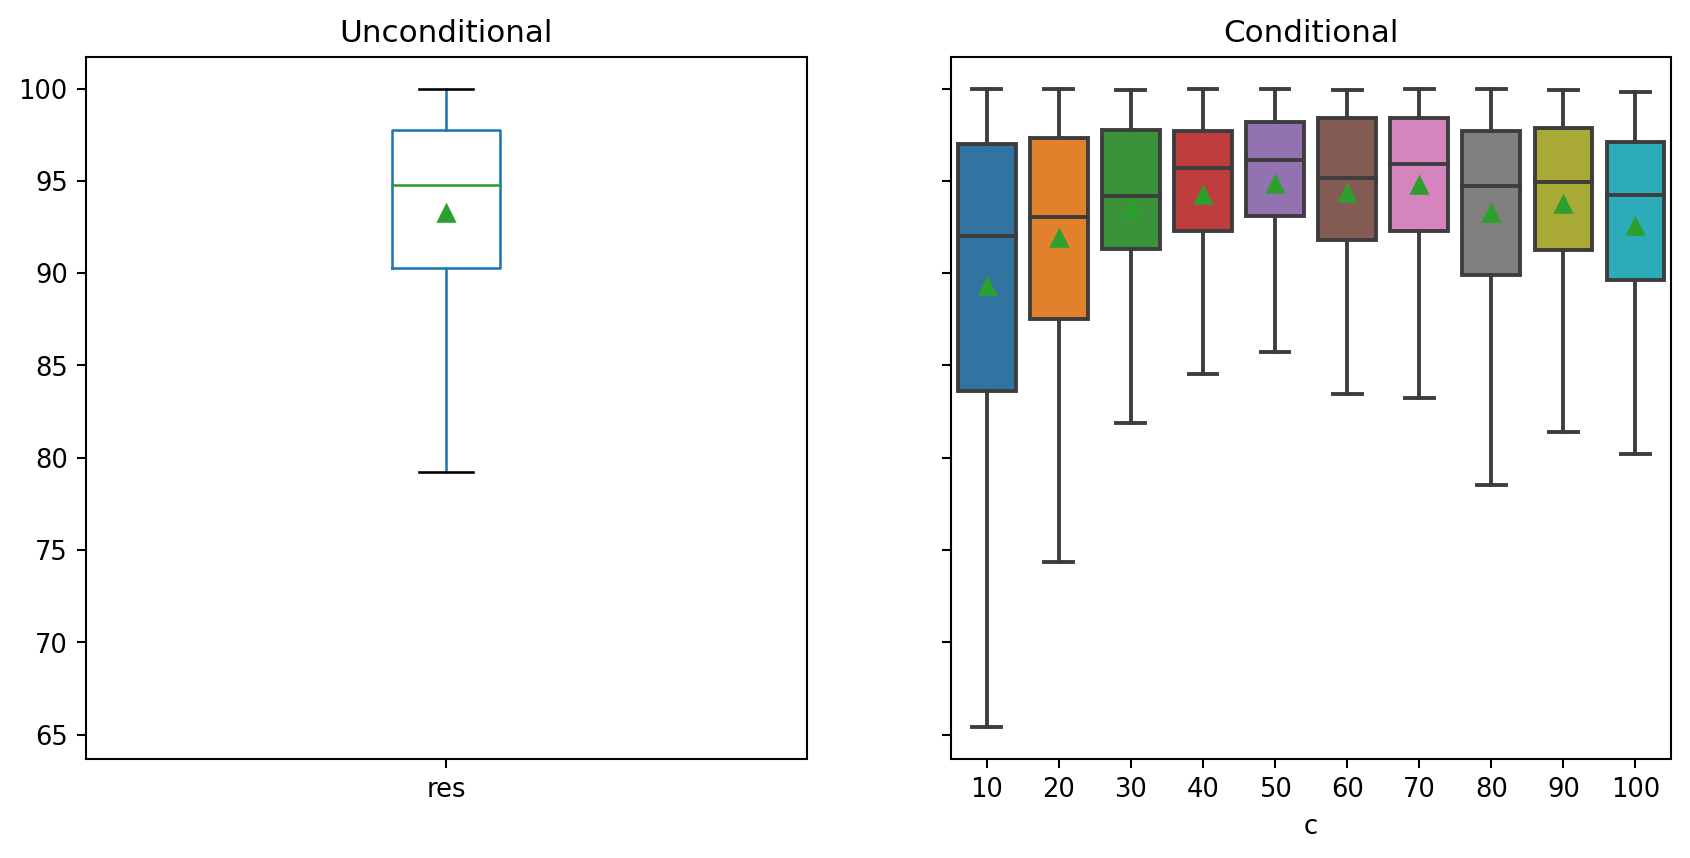

In [3285]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(11,5), sharey=True)
df[["res"]].boxplot(showmeans=True,ax=axes[0],grid=False,showfliers=False); axes[0].set_title("Unconditional")
sns.boxplot(data=df, x="c", y="res",showmeans=True,ax=axes[1],showfliers=False);  axes[1].set_title("Conditional");plt.ylabel(None)

The reward distribution looks how we would have expect it. The theoretical optimum is approximately the same when simulating (70).

## 2.) Gridworld

**Note** : In my implementation I am using a different coordinate system with the origin at the left corner and numeration from 0 to 8.


In [3175]:
class Environment:
    def __init__(self, size, travel_cost):
        self.size = size
        self.states = {(x, y) : {"terminal" : False,
                                 "reward" : travel_cost,
                                 "reachable" : True} for x in range(size) for y in range(size)}
        self.player_location = None
    def add_terminal(self,loc, reward):
        self.states[loc]["reward"] = reward
        self.states[loc]["terminal"] = True
    def add_barrier(self, loc):
        if loc=="random":
            available_slots = [s for s in self.states if not any([self.states[s]["terminal"], not self.states[s]["reachable"], s==self.player_location]) ]
            loc = random_select(available_slots)
        self.states[loc]["reward"] = None
        self.states[loc]["reachable"] = False
    def plot(self,alpha=1):
        grid=np.zeros((self.size, self.size))
        for state in self.states:
            if self.states[state]["terminal"]:
                grid[state] = -5.5
            elif self.states[state]["reachable"]:
                grid[state] = -2.
        if self.player_location is not None:
            ax = plt.imshow(grid.T,origin="lower")
            return plt.scatter([self.player_location[0]],[self.player_location[1]], c="red", alpha=alpha)
        else:
            return plt.imshow(grid.T,origin="lower")
    def feedback(self, state, action):
        if action == "L":
            next_state = (state[0]-1, state[1])
        elif action == "R":
            next_state = (state[0]+1, state[1])
        elif action == "U":
            next_state = (state[0], state[1]+1)
        elif action == "D":
            next_state = (state[0], state[1]-1)
        if next_state not in self.states:
            next_state = state
        elif not self.states[next_state]["reachable"]:
            next_state = state
        reward = self.states[next_state]["reward"]
        self.player_location = next_state
        return next_state, reward
            

For policy evaluation I create a small class called Player to actualize the given policy. Although the policy evaluation could be done purely functional, I will extend the class for later experiments.

In [1408]:
class Player:
    def __init__(self, spawn):
        self.collected_rewards = 0
        self.state = spawn
    def act(self, environment, policy=None):
        state = self.state
        if policy is not None:
            action = np.random.choice(a=["L", "R", "U", "D"],p=policy)
        else:
            pass
        next_state, reward = environment.feedback(state, action)
        self.state = next_state
        self.collected_rewards += reward

Below the environment is built.

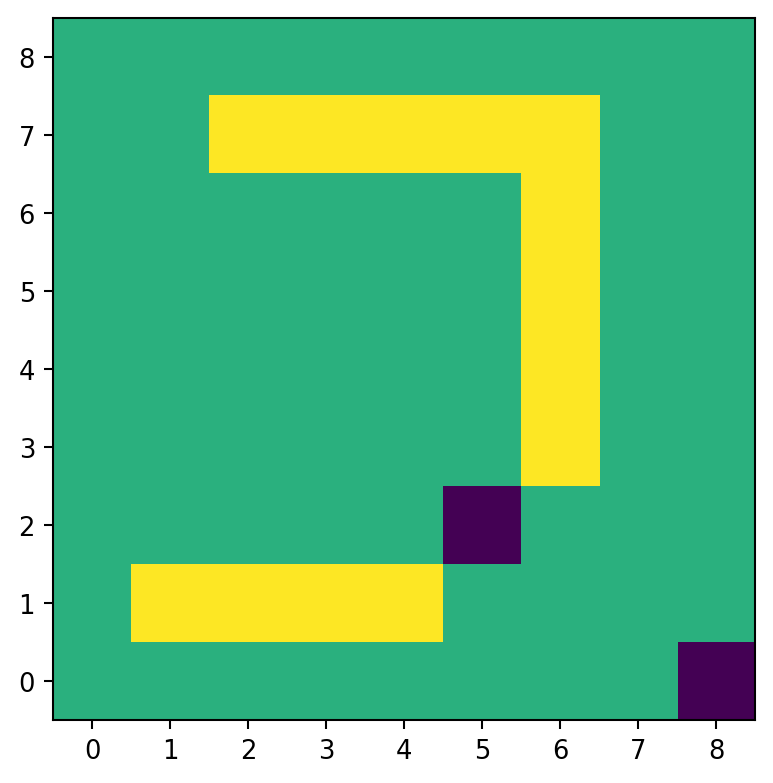

In [3171]:
# Instanciate
env = Environment(size=9, travel_cost=-1)
# Add the barriers
[env.add_barrier((x,1)) for x in range(1,5)]
[env.add_barrier((x,7)) for x in range(2,7)]
[env.add_barrier((6,y)) for y in range(3,8)]
# Add the snakepit and the treasure
env.add_terminal(loc = (5,2), reward = -50)
env.add_terminal(loc = (8,0), reward = 50)
# Show env
env.plot()

### Monte Carlo Policy Evaluation

In [1411]:
def MCTS_sample(environment, state, policy):
    player = Player(spawn=state)
    while not environment.states[player.state]["terminal"]:
        player.act(environment, policy)
    return player.collected_rewards

In [1524]:
%%time
episodes_per_state = 5_000
policy = [.25,.25,.25,.25]

grid = np.zeros((9,9))
for state in env.states:
    if not any([env.states[state]["terminal"], not env.states[state]["reachable"]]):
        R_s = [MCTS_sample(env, state, policy) for episode in range(episodes_per_state)]
        grid[state] = np.mean(R_s)
    else:
        continue

CPU times: user 23min 26s, sys: 57.6 s, total: 24min 23s
Wall time: 1h 16min 1s


Text(0.5, 1.0, '$V_{\\pi}(s)$')

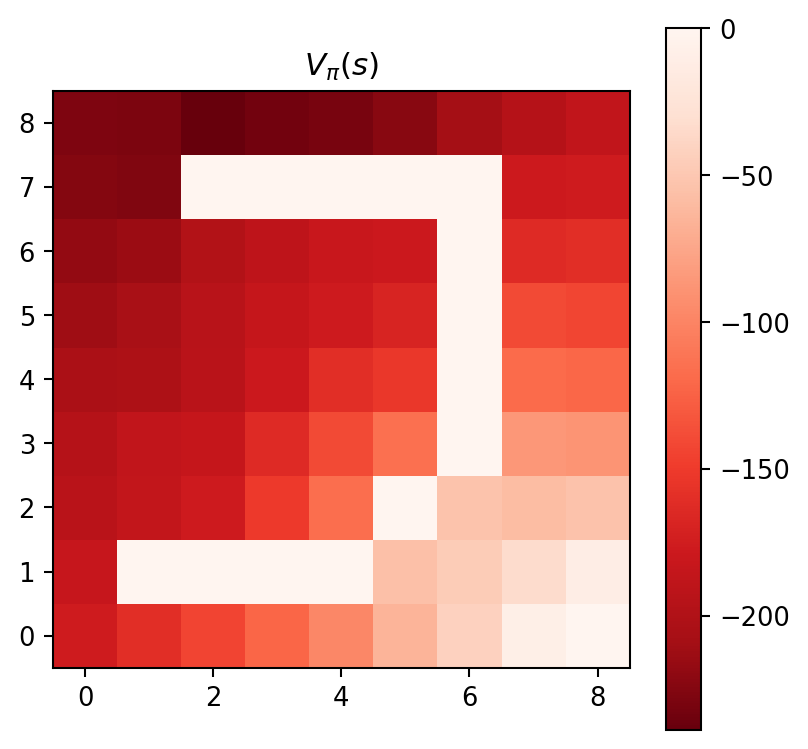

In [1656]:
plt.imshow(grid.T,origin="lower",cmap="Reds_r",interpolation="none");plt.colorbar();plt.title("$V_{\pi}(s)$")

## SARSA and Q-Learning

Now first I am going to extend the `Player` class in a way that the player can collect experience over time. Note that the player can only store information about the environment by acting in the environment, obtained via `environment.feedback()`. Now I am also adding the environment to the constructor of the player. This wont give the player any additional information, but serves as a template to initialize arbitrary q values for the states at spawn.

In [3230]:
class Player:
    def __init__(self, environment, spawn="random",epsilon=None,gamma=1,alpha=1):
        self.viable_states = [s for s in environment.states if not any([environment.states[s]["terminal"], not environment.states[s]["reachable"]])]
        self.Q = {(s, a) : 0 for s in environment.states for a in ["R","L","U","D"]}
        self.gamma = gamma
        self.alpha = alpha
        self.n_episodes = 0
        self.epsilon = epsilon
        self.state = spawn if spawn!="random" else random_select(self.viable_states)
        self.policy = {state : ["L","R","U","D"] for state in environment.states}
        self.env_dim = environment.size
    def choice(self, state):
        policy_action = self.policy[state]
        if np.random.binomial(1, self.epsilon) == 0:
            return policy_action[0] if len(policy_action) == 0 else random_select(policy_action)
        else:
            other_actions = [_ for _ in ["L","R","U","D"] if _ not in policy_action ]
            return random_select(other_actions) if len(other_actions) != 0 else random_select(policy_action)
    def respawn(self, environment, spawn="random"):
        self.state = spawn if spawn!="random" else random_select([s for s in environment.states if not any([environment.states[s]["terminal"], not environment.states[s]["reachable"]])])                                                                                
    def act(self, environment):
        state = self.state
        action = self.choice(state)
        next_state, reward = environment.feedback(state, action)
        self.state = next_state
        self.Q[(state, action)] += self.alpha*(reward + self.gamma*self.Q[(next_state, self.choice(next_state))] - self.Q[(state, action)] )
        return reward
    def episode(self, environment, spawn="random"):
        collected_rewards = 0
        self.respawn(environment, spawn)
        while not environment.states[self.state]["terminal"]:
            collected_rewards += self.act(environment)
        self.n_episodes += 1
        return collected_rewards
    def greedify_policy(self):
        for state in self.viable_states:
            q_s = [q for q in self.Q if q[0] == state]
            q_s_vals = [self.Q[q] for q in q_s]
            a_q = [q[1] for q in q_s if self.Q[q] == max(q_s_vals)]
            self.policy[state] = a_q
    def show_policy(self):
        grid=np.zeros((self.env_dim, self.env_dim))
        fig, ax = plt.subplots()
        ax.imshow(grid.T,origin="lower")
        for state in self.policy:
            x, y = state
            ax.text(x,y, "".join(self.policy[state]), ha="center", va="center", c="white")

## 1.) SARSA Policy Iteration with $\epsilon$-greedy

### Working Example

In [3065]:
start = (0,8)
agent0 = Player(environment=env, spawn=start,epsilon=2/3,gamma=2/3, alpha=2/3)

The initial Policy is random :

Text(0.5, 1.0, 'Initial (Random) Policy')

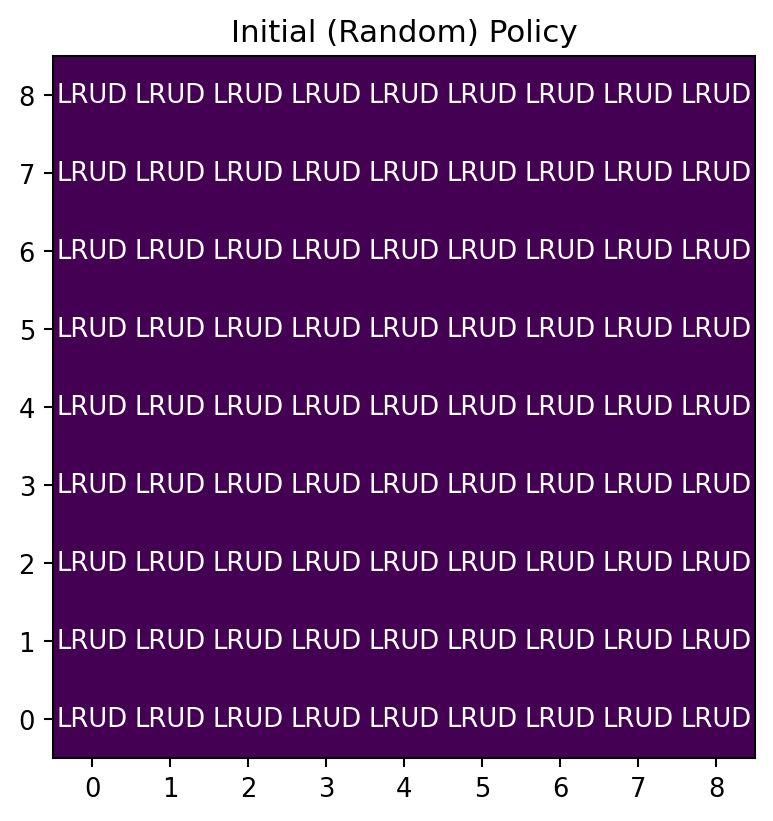

In [3066]:
agent0.show_policy();plt.title("Initial (Random) Policy")

After each iteration, the policy is adjusted in a greedy manner (with random exploration)

Text(0.5, 1.0, 'Policy Adjustment after a single episode')

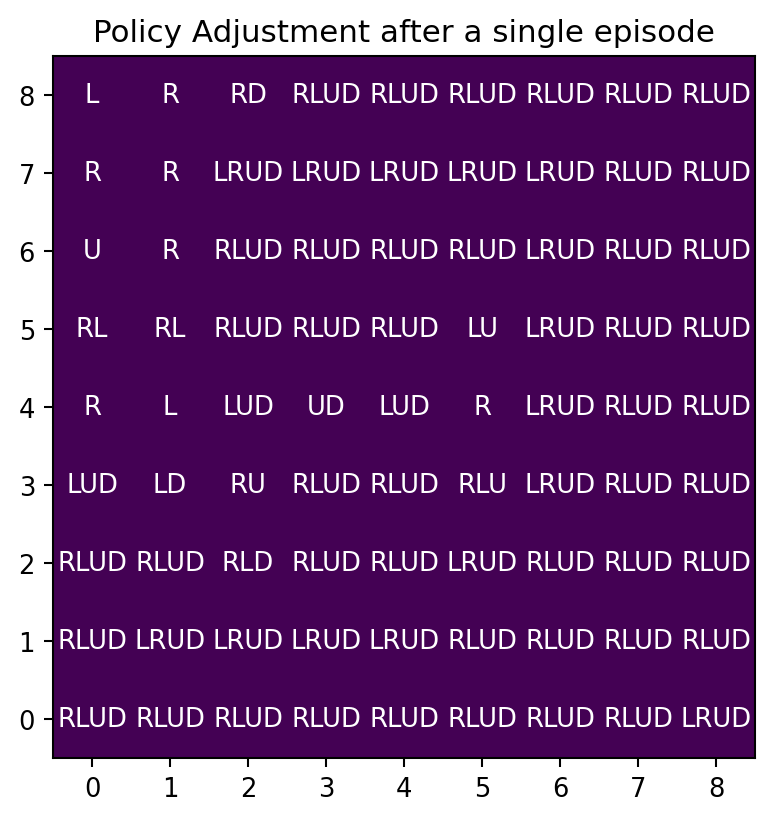

In [3067]:
agent0.episode(environment=env, spawn=start)
agent0.greedify_policy()
agent0.show_policy();plt.title("Policy Adjustment after a single episode")

Text(0.5, 1.0, 'Policy Adjustment after second episode')

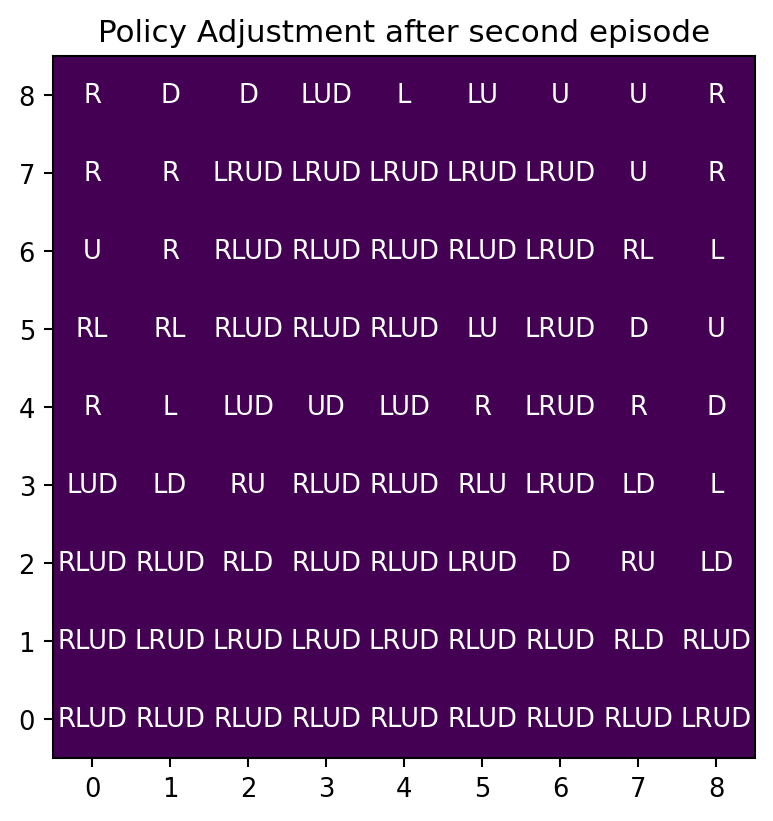

In [3068]:
agent0.episode(environment=env, spawn=start)
agent0.greedify_policy()
agent0.show_policy();plt.title("Policy Adjustment after second episode")

#### Experiment Setup / Agent characteristics

For the following experiments, assume the following setup

$$
\alpha =\frac{5}{100}
$$

$$
\gamma = \frac{90}{100} \\
$$

$$
\epsilon_{0} = \frac{2}{3}
$$

## Full Run with static initialization

Now for a full run of $T=500$ episodes, I will let the agent respawn at (0,8) for each episode. Epsilon will decay according to the following rule that in my experience works fine:

$$
\epsilon_t = \frac{\epsilon_0}{t^{\frac{t}{T}}}
$$

with initial epsilon $\epsilon_0$.

Text(0.5, 1.0, 'Policy found by SARSAPlayer (static init)')

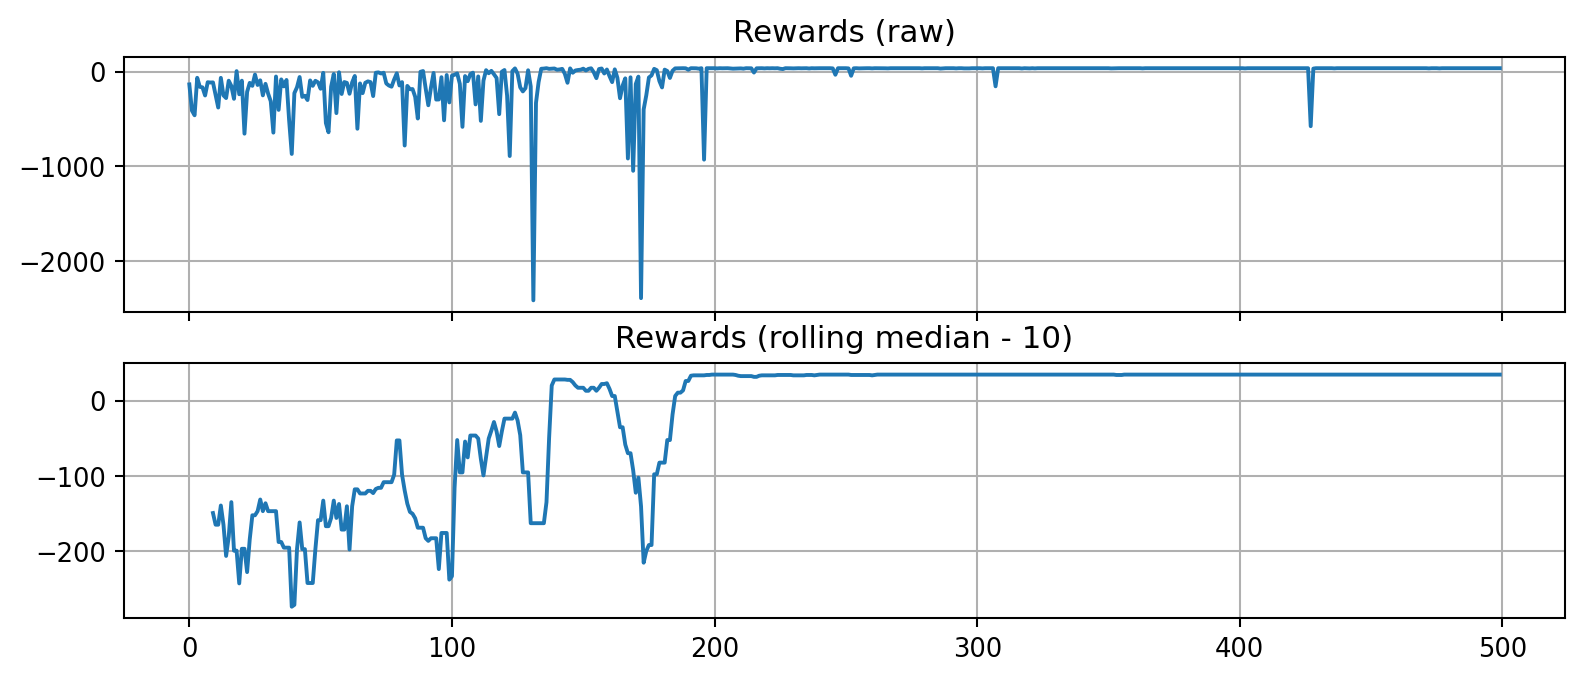

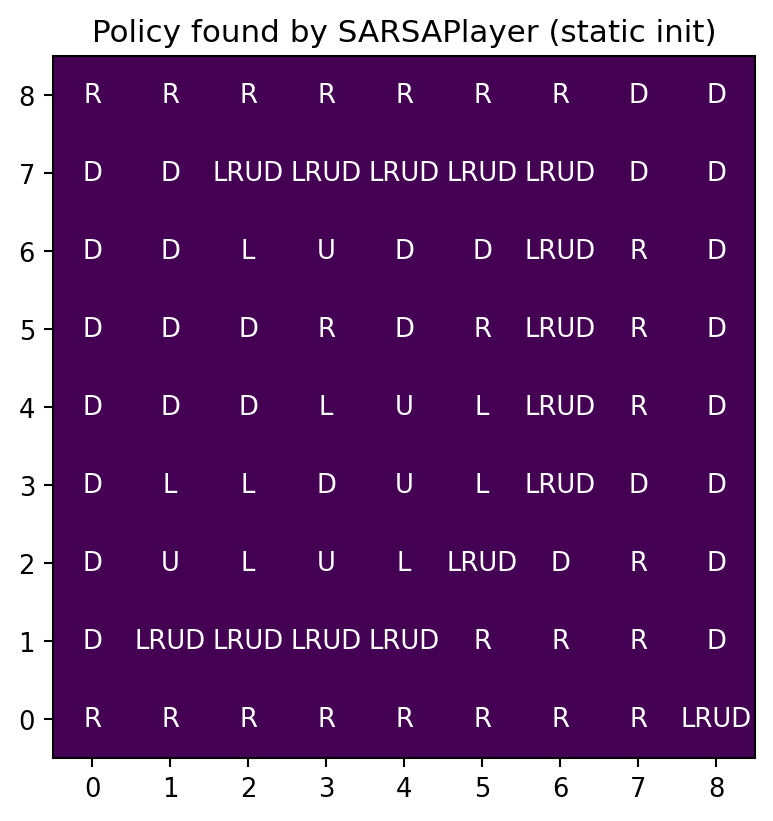

In [3083]:
start = (0,8)
T = 500
e_init = 2/3
alpha= 0.05
gamma = 9/10
agent = Player(environment=env, spawn=start,gamma=gamma, alpha=alpha)
rewards = []
for t in range(1, T+1):
    agent.epsilon = e_init/t**(t/T)
    rewards.append(agent.episode(environment=env, spawn=start))
    agent.greedify_policy()
R = pd.Series(rewards)
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,4), sharex=True)
R.plot(ax=axes[0],grid=True, title="Rewards (raw)")
R.rolling(10).median().plot(ax=axes[1],grid=True,title="Rewards (rolling median - 10)")
agent.show_policy();plt.title("Policy found by SARSAPlayer (static init)")

The above figure reveals a non-unique local policy, which is only considered optimal with respect to the spawning state (0,8). Obviously this is policy isnt globally optimal.


With static initialization, we cannot sample the all states efficiently.If we add considerable more noise by random initialization of the spawn state and much more total iterations, we can try to find a global optimal policy that yields optimality regardless of the starting state.

## Full run with random initialization

Text(0.5, 1.0, 'Policy found by SARSAPlayer (random init)')

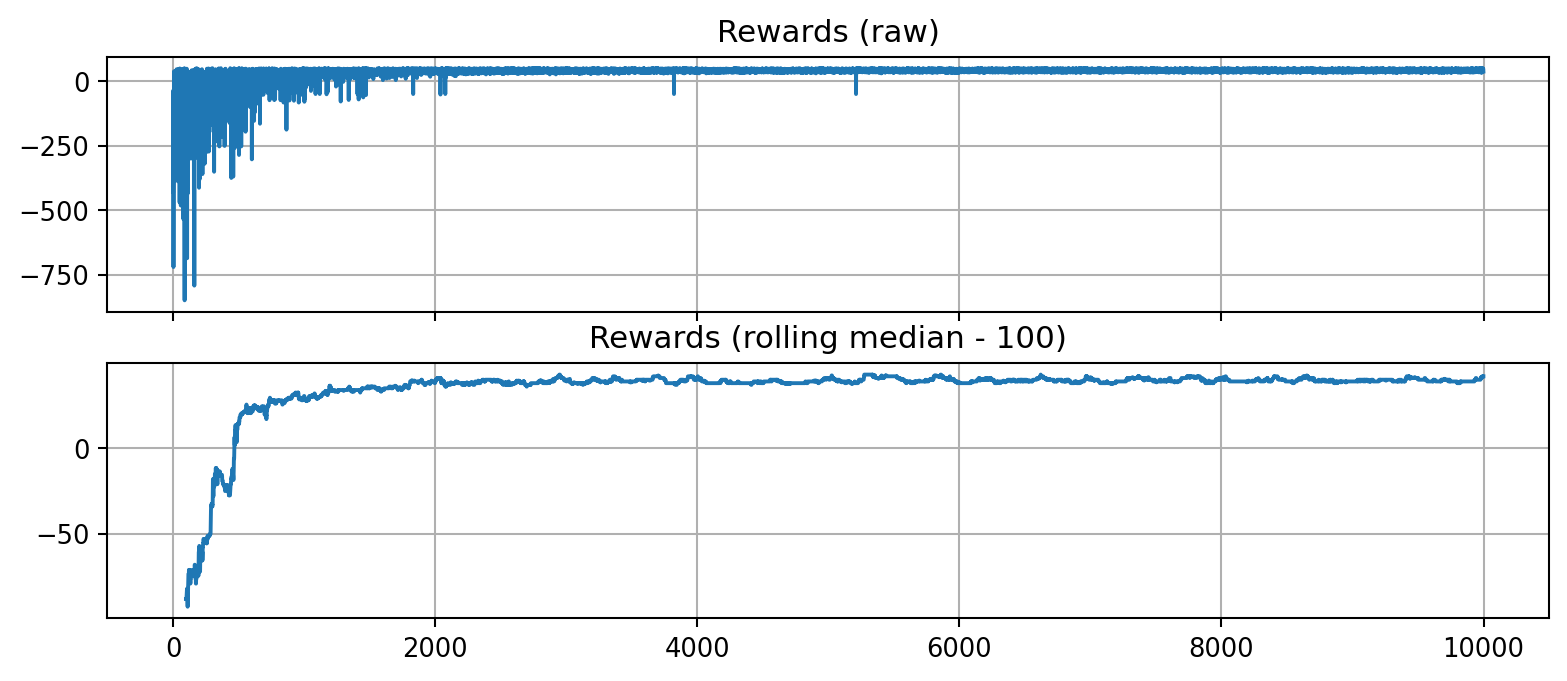

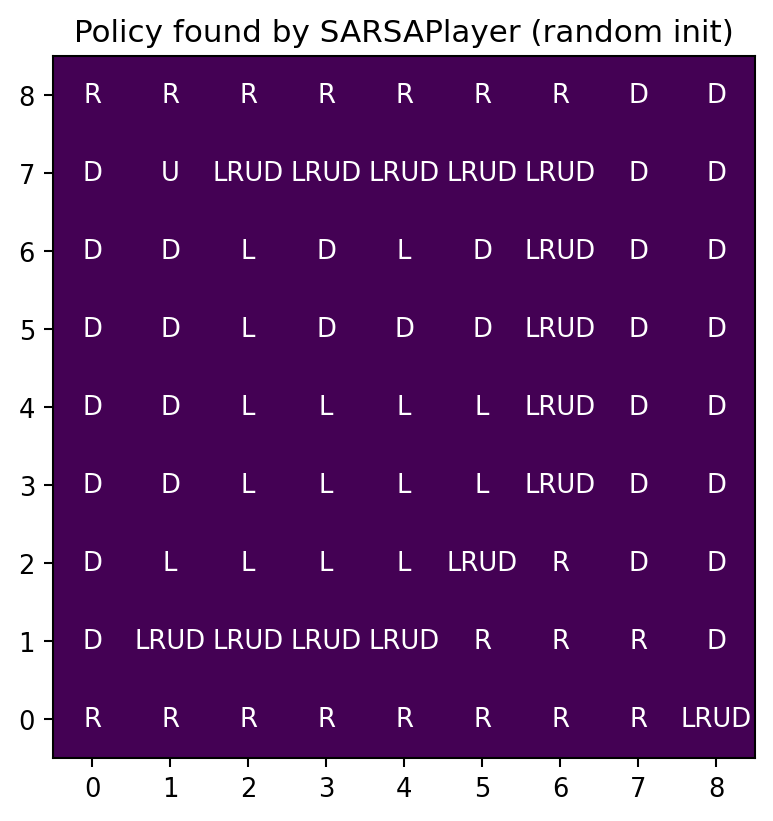

In [3114]:
start = "random"
SARSAagent = Player(environment=env, spawn=start,gamma=9/10, alpha=5/100)
T = 10_000
e_init = 2/3
rewards = []
for t in range(1, T+1):
    SARSAagent.epsilon = e_init/t**(t/T)
    SARSAagent.greedify_policy()
    rewards.append(SARSAagent.episode(environment=env, spawn=start))
R = pd.Series(rewards)
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,4), sharex=True)
R.plot(ax=axes[0],grid=True, title="Rewards (raw)")
R.rolling(100).median().plot(ax=axes[1],grid=True,title="Rewards (rolling median - 100)")
SARSAagent.show_policy();plt.title("Policy found by SARSAPlayer (random init)")

Now we can see a more "fine tuned" policy that has been built by randomly iitializing the player at each episode.

<AxesSubplot:title={'center':'SARSAPlayer - Estimated Reward Density (Post-Training)'}, ylabel='Density'>

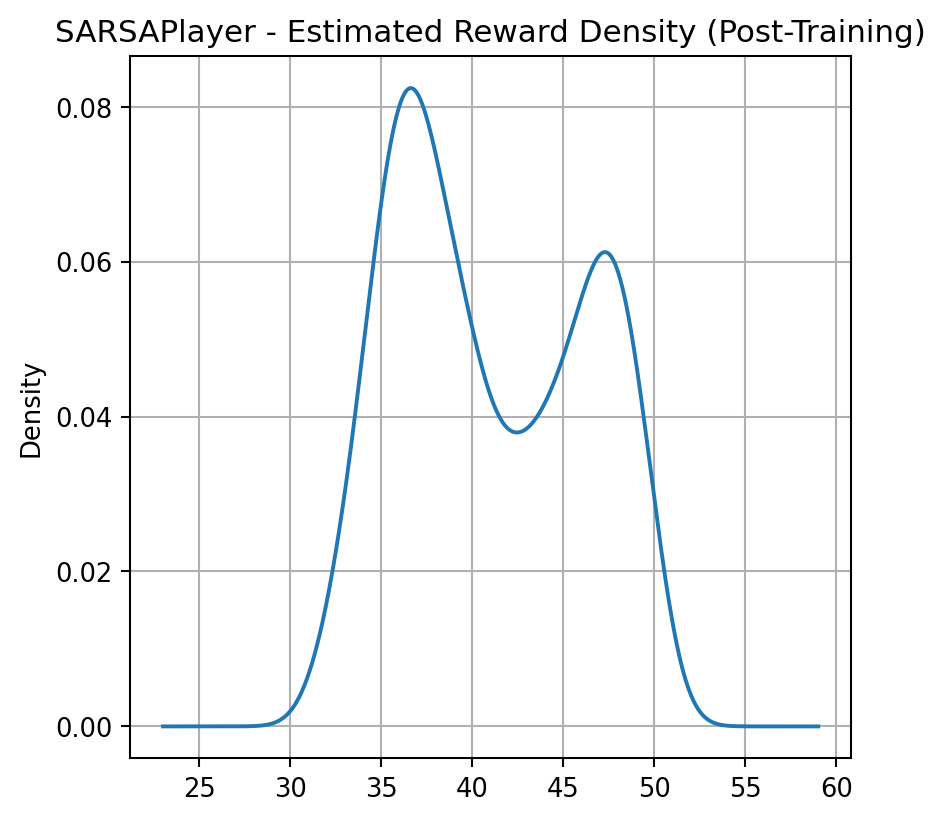

In [3104]:
pd.Series([SARSAagent.episode(env) for _ in range(1000)]).plot.kde(grid=True,title="SARSAPlayer - Estimated Reward Density (Post-Training)")

Letting the agent play the game for another 1000 iterations without updating the policy $\pi_{\text{SARSA}}$ reveals a bimodal reward density $R_{\pi_{\text{SARSA}}}$. The shown distribution is technically a Monte Carlo estimate of the entire game with respect to $\pi_{\text{SARSA}}$.

## 2.) Q - Learning

Now, instead of updating an initial policy $\pi$ by greedification, the agent can do its decision making explicitly by choosing actions with the highest q value along the environment. Given the fact that SARSA greedifies a policy with maximum q-values, I expect Q-Learning to yield essentially the same result, since updating q values by acting in the environment will fine tune the q values over time in the same way SARSA fine tunes a policy. The only thing that I suspect is that the discretization of $Q(s,a) \in \mathcal{R}$ into a policy $\pi : s \to a$ could make SARSA a little bit less efficient given $s \in [R,L,U,D]$, but this is just my intuition. 

For the Q-Learning player I modify the `Player` class slighty to make the player choose actions explicitly based on the Q table (In my implementation its a simple mapping, not an actual table).

In [3186]:
class QPlayer:
    def __init__(self, environment, spawn="random",epsilon=None,gamma=1,alpha=1):
        self.viable_states = [s for s in environment.states if not any([environment.states[s]["terminal"], not environment.states[s]["reachable"]])]
        self.Q = {(s, a) : 50 for s in environment.states for a in ["R","L","U","D"]}
        self.gamma = gamma
        self.alpha = alpha
        self.n_episodes = 0
        self.epsilon = epsilon
        self.state = spawn if spawn!="random" else random_select(self.viable_states)
        self.policy = {state : ["L","R","U","D"] for state in environment.states}
        self.env_dim = environment.size
    def choice(self, state):
        q_s = [q for q in self.Q if q[0] == state]
        q_s_vals = [self.Q[q] for q in q_s]
        a_q_max = [q[1] for q in q_s if self.Q[q] == max(q_s_vals)]
        self.policy[state] = a_q_max
        if np.random.binomial(1, self.epsilon) == 0:
            return a_q_max[0] if len(a_q_max)==1 else random_select(a_q_max)
        else:
            other_actions = [_ for _ in ["L","R","U","D"] if _ not in a_q_max ]
            return random_select(other_actions) if len(other_actions) != 0 else random_select(["L","R","U","D"])
    def respawn(self, environment, spawn="random"):
        self.state = spawn if spawn!="random" else random_select([s for s in environment.states if not any([environment.states[s]["terminal"], not environment.states[s]["reachable"]])])                                                                                
    def act(self, environment):
        state = self.state
        action = self.choice(state)
        next_state, reward = environment.feedback(state, action)
        self.state = next_state
        self.Q[(state, action)] += self.alpha*(reward + self.gamma*self.Q[(next_state, self.choice(next_state))] - self.Q[(state, action)] )
        return reward
    def episode(self, environment, spawn="random"):
        collected_rewards = 0
        self.respawn(environment, spawn)
        while not environment.states[self.state]["terminal"]:
            collected_rewards += self.act(environment)
        self.n_episodes += 1
        return collected_rewards
    def show_policy(self):
        grid=np.zeros((self.env_dim, self.env_dim))
        fig, ax = plt.subplots()
        ax.imshow(grid.T,origin="lower")
        for state in self.policy:
            x, y = state
            ax.text(x,y, "".join(self.policy[state]), ha="center", va="center", c="white")
        return ax

## Full run with random initialization

For the QPlayer, I skip the part with static initialization and start right away with the full run with random init. All other parameters stay the same of course.

Text(0.5, 1.0, 'Policy found by QPlayer')

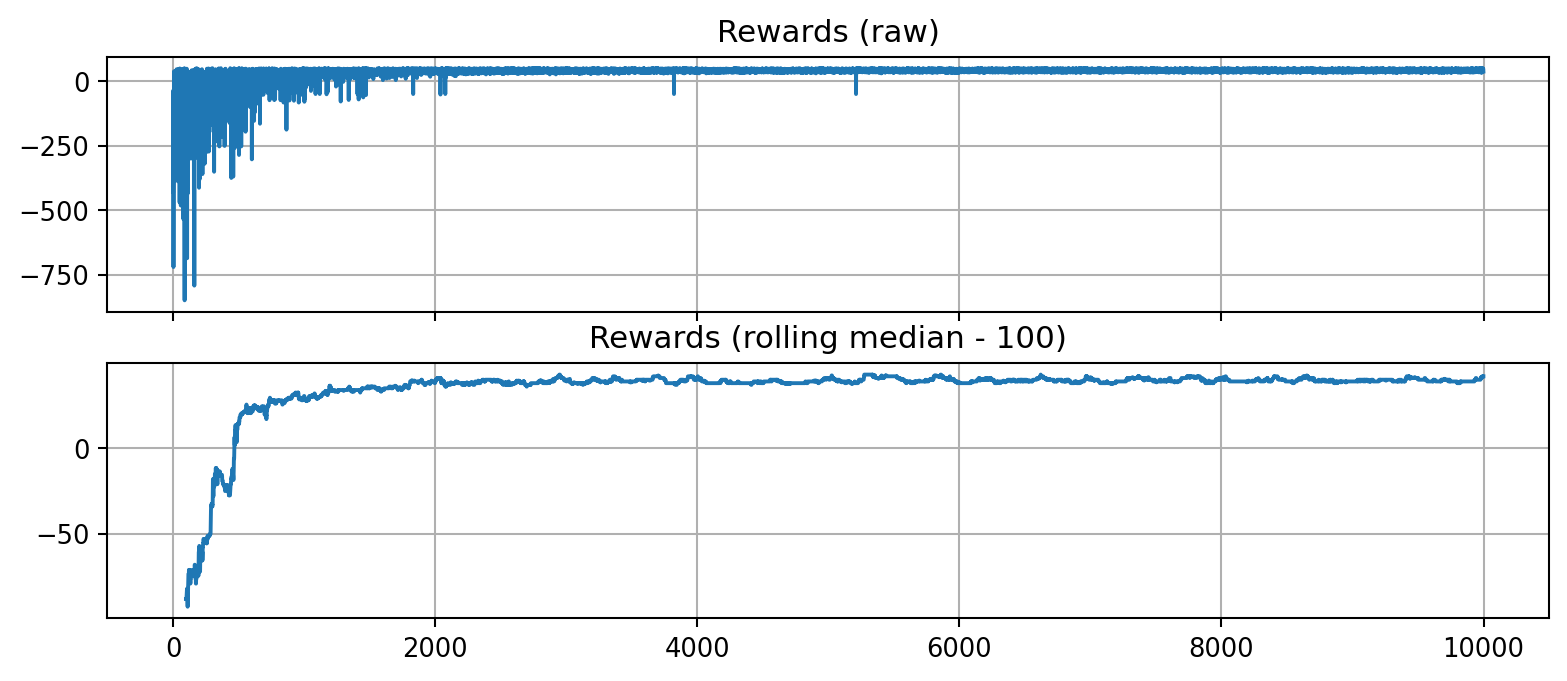

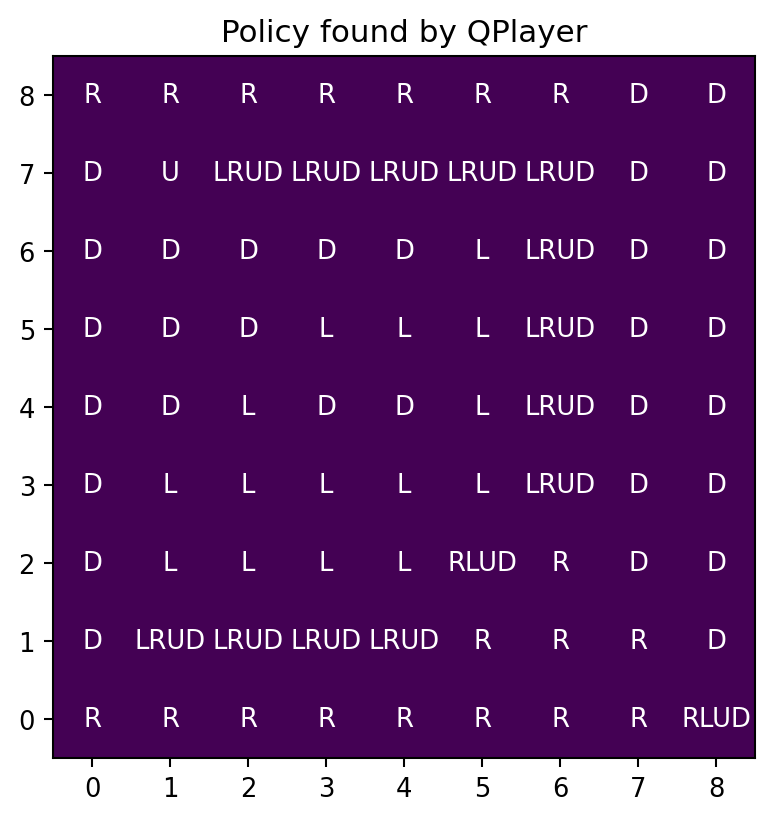

In [3113]:
start = "random"
Qagent = QPlayer(environment=env, spawn=start,gamma=9/10, alpha=5/100)
T = 10_000
e_init = 2/3
rewards = []
for t in range(1, T+1):
    Qagent.epsilon = e_init/t**(t/T)
    rewards.append(Qagent.episode(environment=env, spawn=start))
R = pd.Series(rewards)
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,4), sharex=True)
R.plot(ax=axes[0],grid=True, title="Rewards (raw)")
R.rolling(100).median().plot(ax=axes[1],grid=True,title="Rewards (rolling median - 100)")
Qagent.show_policy();plt.title("Policy found by QPlayer")

<AxesSubplot:title={'center':'QPlayer - Estimated Reward Density (Post-Training)'}, ylabel='Density'>

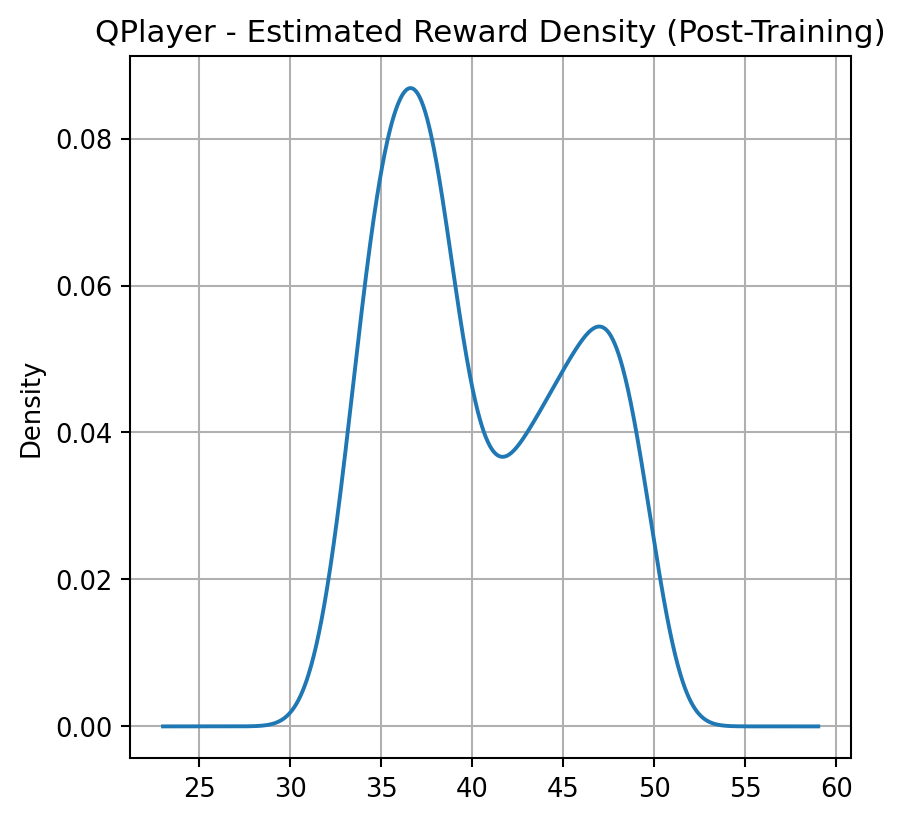

In [3109]:
pd.Series([Qagent.episode(env) for _ in range(1000)]).plot.kde(grid=True,title="QPlayer - Estimated Reward Density (Post-Training)")

The MC Game estimate for the policy that is being (indirectly) implemented by Q-Learning looks extremely similar to SARSA's.

### Comparison
Due to the non-uniqueness and randomness the two policies might not be identical after a single (full) training run, however the reward density should be equivalent for both policies.

Text(0.5, 1.0, 'SARSA')

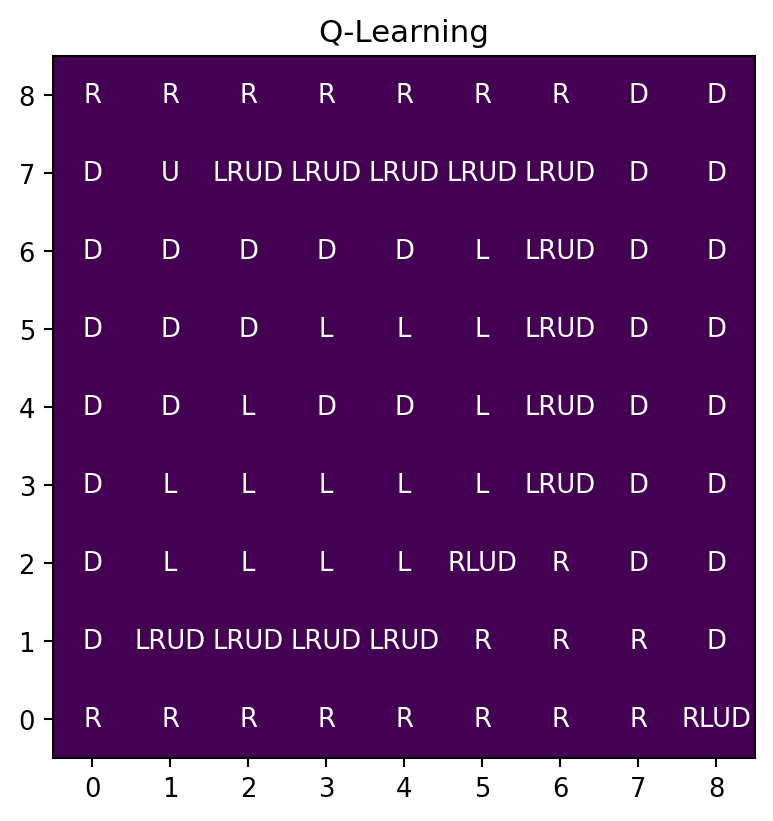

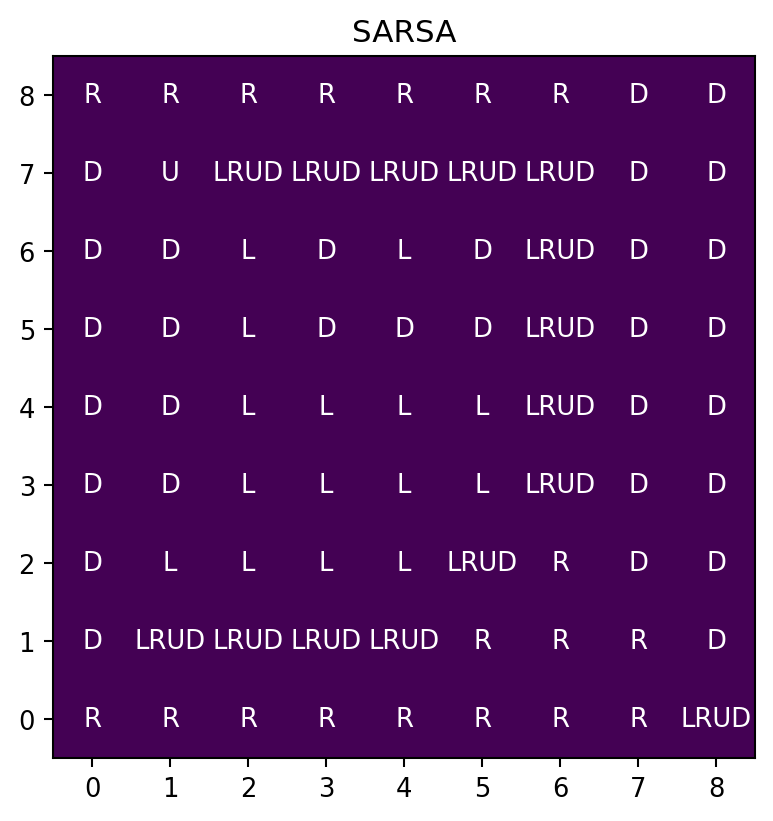

In [3152]:
Qagent.show_policy();plt.title("Q-Learning")
SARSAagent.show_policy();plt.title("SARSA")

In [3126]:
Qagent.epsilon = 0
SARSAagent.epsilon = 0
R_joint = pd.DataFrame({"SARSA" : [SARSAagent.episode(env) for _ in range(10_000)],
                        "Q-Learning" : [Qagent.episode(env) for _ in range(10_000)]})


<AxesSubplot:ylabel='Density'>

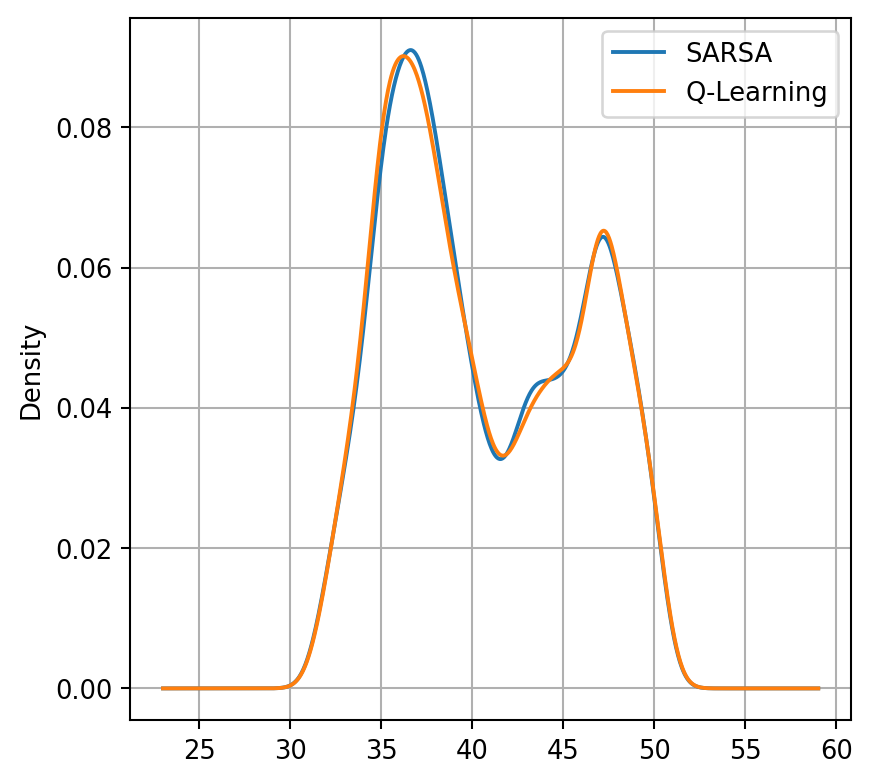

In [3141]:
R_joint.plot.kde(grid=True)

In [3151]:
R_joint.describe()

,SARSA,Q-Learning
count,10000.000000,10000.000000
mean,40.703900,40.680100
std,5.178446,5.204928
min,32.000000,32.000000
25%,36.000000,36.000000
50%,39.000000,39.000000
75%,46.000000,46.000000
max,50.000000,50.000000


As expected, the MC-Game estimates are almost identical.

## Learning Efficiency : Policy Adjustment in non-stationary environments

Both algorithms will fail in non-stationary environments. As an example, consider an empty environment with a snake pit and a reward state, where barriers are randomly added every $N_c$ iterations. This task can actually be solved if the players have information about $N_c$. If its random, the players need the density, if it is constant, the players need this constant. Given the players can approximate $N_c$, they can recalibrate learning (most importantly $\epsilon$) and re-learn the Q-Map. Obtaining estimates about $N_c$ is trivial in this example, but could be infeasable in other environments.

For this small synthetic example consider a deterministic $N_c$ as known, such that the player is able to adjust/reset $\epsilon$ . Then the problem is equivalent to solving a sequence of games. If we implement that, we can learn about the learning efficiency of both algorithms, which should theoretically be the same.

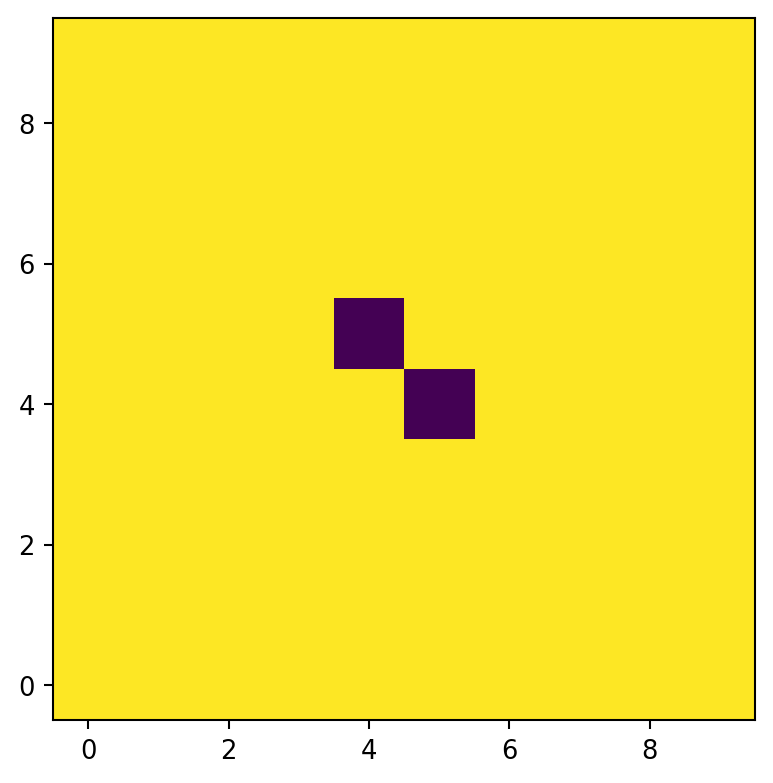

In [3241]:
# Instanciate
env = Environment(size=10, travel_cost=-1)
# Add the snakepit and the treasure
env.add_terminal(loc = (4,5), reward = -100)
env.add_terminal(loc = (5,4), reward = 100)
# Show env
env.plot()

<AxesSubplot:title={'center':'Rewards (rolling Mean - 100)'}>

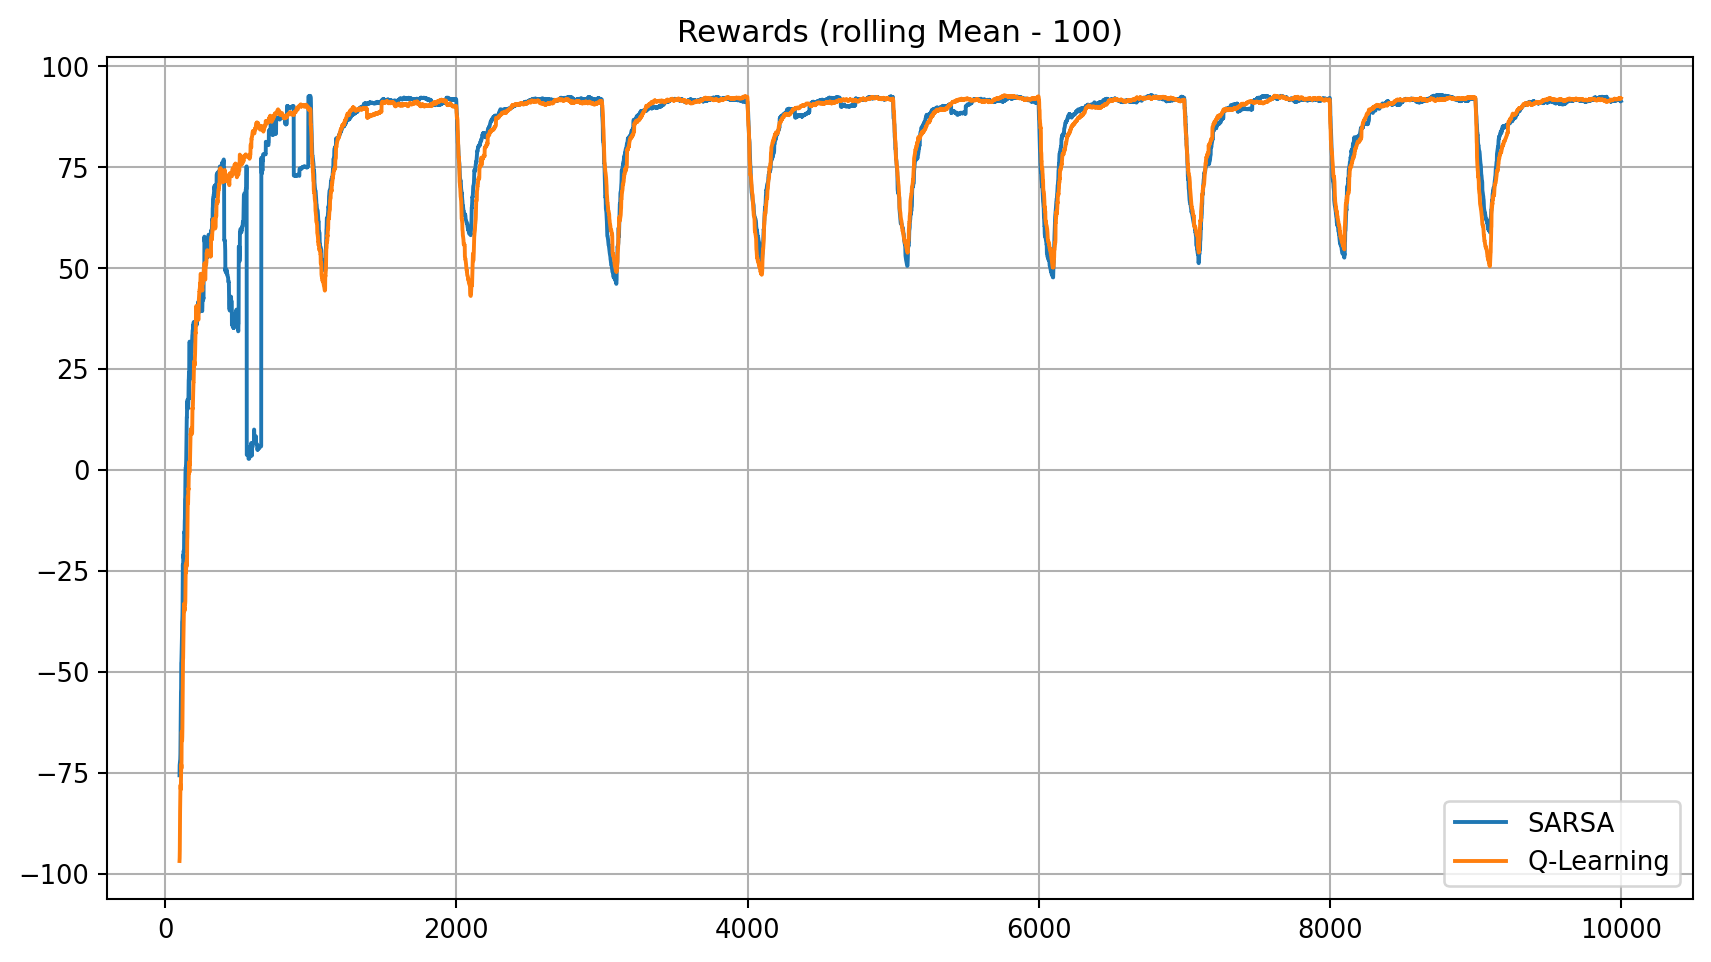

In [3238]:
start = "random"
SARSAagent = Player(environment=env, spawn=start,gamma=9/10, alpha=5/100)
Qagent = QPlayer(environment=env, spawn=start,gamma=9/10, alpha=5/100)
e_init=2/3
T = 1000
rewardsQ, rewardsSARSA = [], []
env_changes=20
for tt in range(1, env_changes+1):
    env.add_barrier(loc="random")
    for t in range(1, T+1):
        Qagent.epsilon = e_init/t**(t/T)
        SARSAagent.epsilon = e_init/t**(t/T)
        rewardsQ.append(Qagent.episode(environment=env, spawn=start))
        rewardsSARSA.append(SARSAagent.episode(environment=env, spawn=start))
        SARSAagent.greedify_policy()
R = pd.DataFrame({"SARSA" : rewardsSARSA, "Q-Learning" : rewardsQ})
R.rolling(100).mean().plot(grid=True,title="Rewards (rolling Mean - 100)",figsize=(11,6))

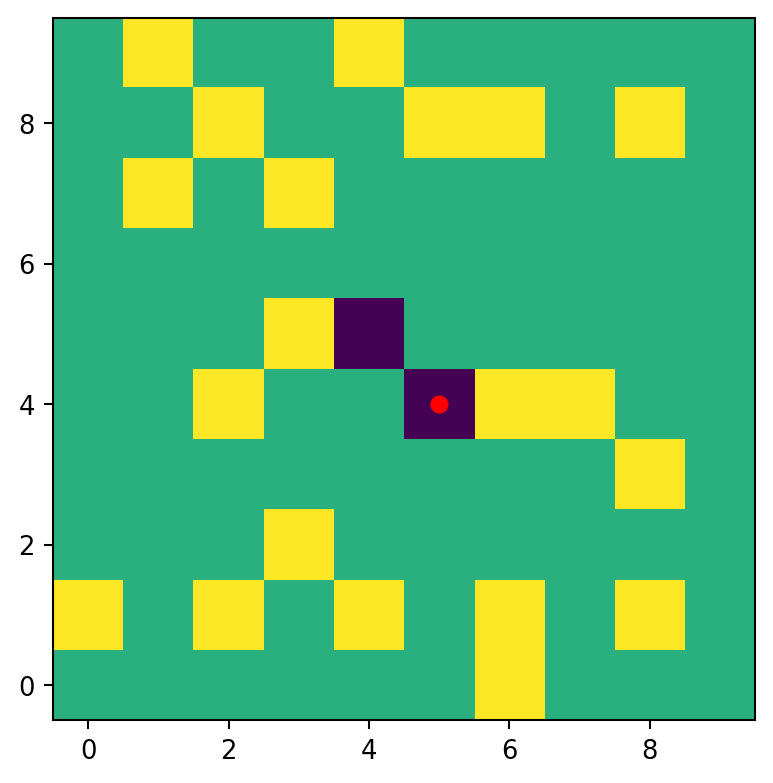

In [3244]:
env.plot()

As expected, the algorithms perform identical in this setup. On average, they are the same.